# 多类分类

In [8]:
# 导入相关包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

In [2]:
# 导入数据集
data = loadmat('ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

In [4]:
def display_data(X,y):
    """数据集可视化展示"""
    pick_one = np.random.randint(0,4999)
    image = X[pick_one,:]
    fig, ax = plt.subplots(figsize=(1,1))
    ax.matshow((image.reshape((20,20)).T),cmap='gray_r') # 图片是镜像的需要通过转置让它看起来更正常
    plt.title(f'{y[pick_one]}')
    plt.xticks([])
    plt.yticks([])
    plt.show()


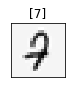

In [5]:
display_data(data['X'], data['y'])

# Sigmoid函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为：
$$g\left( z \right)=\frac{1}{1+{{e}^{-z}}}$$ 
逻辑回归模型的假设函数： 
	$${{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}$$

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 正则化代价函数
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [7]:
def costReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X*theta.T)))
    second = np.multiply(1-y, np.log((1-sigmoid(X*theta.T))))
    reg = (learningRate / (2*len(X)))*np.sum(np.power(theta[:,1:theta.shape[1]],2))
    return np.sum(first-second) / len(X) + reg

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a[\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}}] \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
$${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$$

## 向量化的梯度函数

In [14]:
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X*theta.T)-y
    grad = ((X.T*error)/len(X)).T+((learningRate/len(X))*theta)
    grad[0,0] = np.sum(np.multiply(error,X[:,0])) / len(X)
    return np.array(grad).ravel()

# 一对多分类器

In [9]:
def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    all_theta = np.zeros((num_labels, params+1))
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    for i in range(1, num_labels+1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        fmin = minimize(fun=costReg, x0=theta, args=(X,y_i,learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:]=fmin.x
    return all_theta

In [11]:
rows = data['X'].shape[0]
params = data['X'].shape[1]
all_theta = np.zeros((10,params+1))
X = np.insert(data['X'],0,values=np.ones(rows),axis=1)
theta = np.zeros(params + 1)
y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows,1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

注意，theta是一维数组，因此当它被转换为计算梯度的代码中的矩阵时，它变为（1×401）矩阵。 我们还检查y中的类标签，以确保它们看起来像我们想象的一致。

In [12]:
np.unique(data['y'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [15]:
all_theta = one_vs_all(data['X'],data['y'],10,1)
all_theta

array([[-2.38264119e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30378388e-03, -6.04752902e-10,  0.00000000e+00],
       [-3.18615506e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46413909e-03, -5.08965285e-04,  0.00000000e+00],
       [-4.79308039e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.87674549e-05, -2.48009888e-07,  0.00000000e+00],
       ...,
       [-7.98804031e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.94738934e-05,  7.21353587e-06,  0.00000000e+00],
       [-4.57092556e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33511750e-03,  9.99030840e-05,  0.00000000e+00],
       [-5.40454691e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16800409e-04,  7.88822670e-06,  0.00000000e+00]])

使用训练完毕的分类器预测每个图像的标签。 对于这一步，我们将计算每个类的类概率，对于每个训练样本，并将输出类标签为具有最高概率的类。

In [22]:
def predict_all(X,all_theta):
    rows = X.shape[0]
    # params = X.shape[1]
    # num_labels = all_theta.shape[0]
    X = np.insert(X,0,values=np.ones(rows),axis=1)
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    h = sigmoid(X * all_theta.T)
    h_argmax = np.argmax(h,axis=1)
    h_argmax = h_argmax + 1
    return h_argmax

使用predict_all函数为每一个实例生成类预测

In [24]:
y_pred = predict_all(data['X'], all_theta)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, data['y'])]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 94.48%


# 神经网络

In [ ]:
weights = loadmat('ex3weights.mat')
data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']
theta1 = weights['Theta1']
theta2 = weights['Theta2']

